In [3]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext('local[*]')
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [5]:
baseDir = '/Users/linamiao/playground/spark/'
irisFourFeatures = sqlContext.read.parquet(baseDir + 'irisFourFeatures.parquet')
print '\n'.join(map(repr, irisFourFeatures.take(2)))

Row(features=SparseVector(4, {0: 0.0556, 1: -0.25, 2: 0.1186, 3: -0.0}), label=1.0)
Row(features=SparseVector(4, {0: -0.5556, 1: -0.5833, 2: -0.322, 3: -0.1667}), label=1.0)


In [7]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT,DenseVector

sparseToDense = udf(lambda sv: Vectors.dense(sv),VectorUDT())
irisDense = irisFourFeatures.select(sparseToDense('features').alias('features'), 'label')

print '\n'.join(map(repr, irisDense.take(2)))

Row(features=DenseVector([0.0556, -0.25, 0.1186, -0.0]), label=1.0)
Row(features=DenseVector([-0.5556, -0.5833, -0.322, -0.1667]), label=1.0)


In [8]:
irisDense.write.mode('overwrite').parquet(baseDir+'irisDense.parquet')

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def prepareSubplot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0, subplots=(1, 1)):
    """Template for generating the plot layout."""
    plt.close()
    fig, axList = plt.subplots(subplots[0], subplots[1], figsize=figsize, facecolor='white',
                               edgecolor='white')
    if not isinstance(axList, np.ndarray):
        axList = np.array([axList])

    for ax in axList.flatten():
        ax.axes.tick_params(labelcolor='#999999', labelsize='10')
        for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
            axis.set_ticks_position('none')
            axis.set_ticks(ticks)
            axis.label.set_color('#999999')
            if hideLabels: axis.set_ticklabels([])
        ax.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
        map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])

    if axList.size == 1:
        axList = axList[0]  # Just return a single axes object for a regular plot
    return fig, axList

In [11]:
matplotlib inline

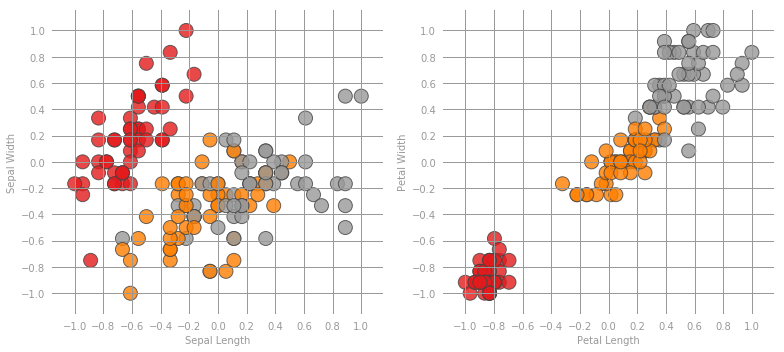

In [12]:
data = irisDense.collect()
features, labels = zip(*data)
x1,y1,x2,y2 = zip(*features)

colorMap = 'Set1'  # was 'Set2', 'Set1', 'Dark2', 'winter'

fig, axList = prepareSubplot(np.arange(-1, 1.1, .2), np.arange(-1, 1.1, .2), figsize=(11., 5.), subplots=(1, 2))
ax0, ax1 = axList

ax0.scatter(x1, y1, s=14**2, c=labels, edgecolors='#444444', alpha=0.80, cmap=colorMap)
ax0.set_xlabel('Sepal Length'), ax0.set_ylabel('Sepal Width')

ax1.scatter(x2, y2, s=14**2, c=labels, edgecolors='#444444', alpha=0.80, cmap=colorMap)
ax1.set_xlabel('Petal Length'), ax1.set_ylabel('Petal Width')

fig.tight_layout()

In [13]:
irisTest, irisTrain = irisDense.randomSplit([0.3,0.7],seed=1)
irisTest.cache()
irisTrain.cache()

DataFrame[features: vector, label: double]

In [15]:
dataTrain = irisTrain.collect()
featuresTrain, labelsTrain = zip(*dataTrain)
x1Train, y1Train, x2Train, y2Train = zip(*featuresTrain)

dataTest = irisTest.collect()
featuresTest, labelsTest = zip(*dataTest)
x1Test, y1Test, x2Test, y2Test = zip(*featuresTest)

trainPlot1 = (x1Train, y1Train, labelsTrain, 'Train Data', 'Sepal Length', 'Sepal Width')
trainPlot2 = (x2Train, y2Train, labelsTrain, 'Train Data', 'Petal Length', 'Petal Width')
testPlot1 = (x1Test, y1Test, labelsTest, 'Test Data', 'Sepal Length', 'Sepal Width')
testPlot2 = (x2Test, y2Test, labelsTest, 'Test Data', 'Petal Length', 'Petal Width')
plotData = [trainPlot1, testPlot1, trainPlot2, testPlot2]

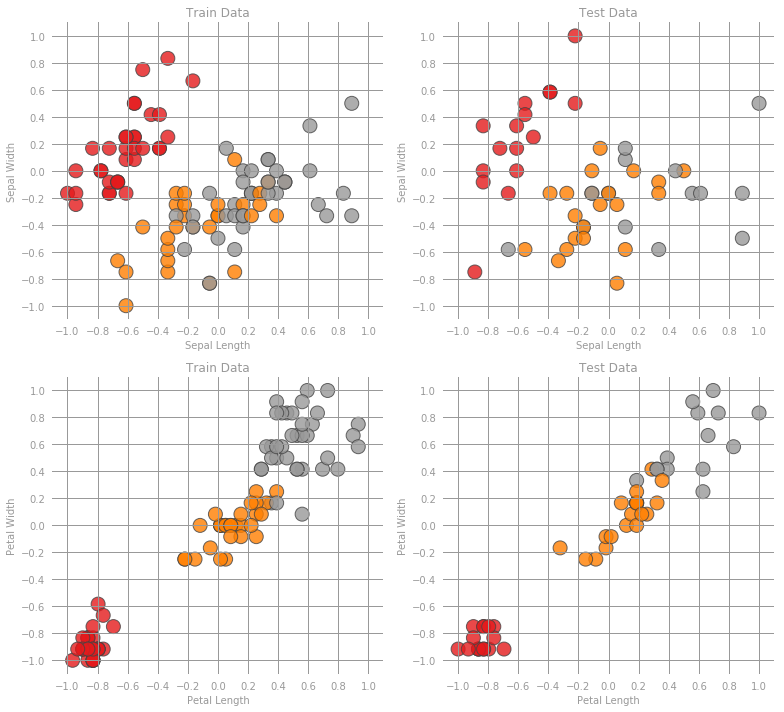

In [16]:
fig, axList = prepareSubplot(np.arange(-1, 1.1, .2), np.arange(-1, 1.1, .2), figsize=(11.,10.), subplots=(2, 2))

for ax, pd in zip(axList.flatten(), plotData):
    ax.scatter(pd[0], pd[1], s=14**2, c=pd[2], edgecolors='#444444', alpha=0.80, cmap=colorMap)
    ax.set_xlabel(pd[4]), ax.set_ylabel(pd[5])
    ax.set_title(pd[3], color='#999999')

    ax.set_xlim((-1.1, 1.1))
    ax.set_ylim((-1.1, 1.1))

fig.tight_layout()

In [27]:
from pyspark.ml.feature import StringIndexer

stringIndexer = (StringIndexer()
                    .setInputCol('label')
                    .setOutputCol('indexed'))

indexModel = stringIndexer.fit(irisTrain)
irisTrainIndexed = indexModel.transform(irisTrain)
irisTrainIndexed.show(15)

+--------------------+-----+-------+
|            features|label|indexed|
+--------------------+-----+-------+
|[-0.611111,0.0833...|  0.0|    1.0|
|[-0.444444,0.4166...|  0.0|    1.0|
|[-0.333333,-0.75,...|  1.0|    2.0|
|[-0.277778,-0.25,...|  1.0|    2.0|
|[-0.222222,-0.583...|  2.0|    0.0|
|[-0.222222,-0.333...|  1.0|    2.0|
|[-0.166667,-0.416...|  1.0|    2.0|
|[-0.166667,-0.333...|  2.0|    0.0|
|[-0.0555556,-0.83...|  1.0|    2.0|
|[-0.0555556,-0.83...|  2.0|    0.0|
|[-1.32455E-7,-0.3...|  1.0|    2.0|
|[-1.32455E-7,-0.3...|  1.0|    2.0|
|[-1.32455E-7,-0.2...|  1.0|    2.0|
|[0.111111,-0.25,0...|  2.0|    0.0|
|[0.166667,-0.25,0...|  1.0|    2.0|
+--------------------+-----+-------+
only showing top 15 rows



In [23]:
print irisTrainIndexed.schema.fields[2].metadata

{u'ml_attr': {u'vals': [u'2.0', u'0.0', u'1.0'], u'type': u'nominal', u'name': u'indexed'}}


In [24]:
from pyspark.ml.classification import DecisionTreeClassifier

In [25]:
dt = (DecisionTreeClassifier()
         .setLabelCol('indexed')
         .setMaxDepth(5)
         .setMaxBins(10)
         .setImpurity('gini'))

In [28]:
dtModel = dt.fit(irisTrainIndexed)
predictionsTest = dtModel.transform(indexModel.transform(irisTest))
predictionsTest.select('label','indexed','prediction').show()

+-----+-------+----------+
|label|indexed|prediction|
+-----+-------+----------+
|  0.0|    1.0|       1.0|
|  1.0|    2.0|       2.0|
|  0.0|    1.0|       1.0|
|  1.0|    2.0|       2.0|
|  1.0|    2.0|       2.0|
|  2.0|    0.0|       0.0|
|  1.0|    2.0|       2.0|
|  1.0|    2.0|       0.0|
|  1.0|    2.0|       2.0|
|  1.0|    2.0|       2.0|
|  1.0|    2.0|       0.0|
|  2.0|    0.0|       0.0|
|  1.0|    2.0|       2.0|
|  1.0|    2.0|       2.0|
|  1.0|    2.0|       2.0|
|  2.0|    0.0|       0.0|
|  2.0|    0.0|       0.0|
|  2.0|    0.0|       2.0|
|  1.0|    2.0|       2.0|
|  1.0|    2.0|       2.0|
+-----+-------+----------+
only showing top 20 rows



In [31]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
multiEval = (MulticlassClassificationEvaluator()
                .setMetricName('f1')
                .setLabelCol('indexed'))
print multiEval.evaluate(predictionsTest)

0.883727016947


In [32]:
dtModelString = dtModel._java_obj.toDebugString()
print dtModelString

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4c0182ee076aeeff385b) of depth 5 with 17 nodes
  If (feature 2 <= 0.254237)
   If (feature 2 <= -0.79661)
    Predict: 1.0
   Else (feature 2 > -0.79661)
    If (feature 1 <= -0.0833334)
     Predict: 2.0
    Else (feature 1 > -0.0833334)
     If (feature 0 <= -0.333333)
      Predict: 1.0
     Else (feature 0 > -0.333333)
      Predict: 2.0
  Else (feature 2 > 0.254237)
   If (feature 3 <= 0.25)
    If (feature 0 <= 0.111111)
     If (feature 0 <= -1.32455E-7)
      If (feature 1 <= -0.583333)
       Predict: 0.0
      Else (feature 1 > -0.583333)
       Predict: 0.0
     Else (feature 0 > -1.32455E-7)
      Predict: 0.0
    Else (feature 0 > 0.111111)
     Predict: 2.0
   Else (feature 3 > 0.25)
    Predict: 0.0



In [34]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.pipeline import Pipeline

cvPipeline = Pipeline().setStages([stringIndexer,dt])

paramGrid = (ParamGridBuilder()
                 .addGrid(dt.maxDepth, [2,4,6,10])
                 .build())

cv = (CrossValidator()
         .setEstimator(cvPipeline)
         .setEvaluator(multiEval)
         .setEstimatorParamMaps(paramGrid)
         .setNumFolds(5))

cvModel = cv.fit(irisTrain)
predictions = cvModel.transform(irisTest)
print multiEval.evaluate(predictions)

0.883727016947


In [35]:
bestDTModel = cvModel.bestModel.stages[-1]
print bestDTModel

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4c0182ee076aeeff385b) of depth 4 with 15 nodes


In [44]:
from pyspark.ml.feature import PolynomialExpansion
px = (PolynomialExpansion()
         .setInputCol('features')
         .setOutputCol('polyFeatures'))
print px.explainParams()
px.transform(irisTest).show(5)

degree: the polynomial degree to expand (>= 1) (default: 2)
inputCol: input column name. (current: features)
outputCol: output column name. (default: PolynomialExpansion_41c5824eb0382787919c__output, current: polyFeatures)
+--------------------+-----+--------------------+
|            features|label|        polyFeatures|
+--------------------+-----+--------------------+
|[-0.833333,0.0,-0...|  0.0|[-0.833333,0.6944...|
|[-0.555556,-0.583...|  1.0|[-0.555556,0.3086...|
|[-0.555556,0.5,-0...|  0.0|[-0.555556,0.3086...|
|[-0.277778,-0.583...|  1.0|[-0.277778,0.0771...|
|[-0.277778,-0.166...|  1.0|[-0.277778,0.0771...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [55]:
from pyspark.ml.classification import RandomForestClassifier
rf = (RandomForestClassifier()
         .setLabelCol('indexed')
         .setFeaturesCol('polyFeatures')
         .setMaxBins(10)
         .setMaxDepth(2)
         .setNumTrees(20)
         .setSeed(0))

rfPipeline = Pipeline().setStages([stringIndexer, px, rf])
rfModelPipeline = rfPipeline.fit(irisTrain)
rfPredictions = rfModelPipeline.transform(irisTest)

print multiEval.evaluate(rfPredictions)


0.904680067674


In [56]:
paramGridRand = (ParamGridBuilder()
                    .addGrid(rf.maxDepth,[2,4,8,12])
                    .baseOn({rf.numTrees,20})
                    .build())

cvRand = (CrossValidator()
             .setEstimator(rfPipeline)
             .setEvaluator(multiEval)
             .setEstimatorParamMaps(paramGridRand)
             .setNumFolds(2))

cvModelRand = cvRand.fit(irisTrain)
predictionsRand = cvModelRand.transform(irisTest)
print multiEval.evaluate(predictionsRand)
print cvModelRand.bestModel.stages[-1]._java_obj.parent().getMaxDepth()

0.941473309256
4


In [57]:
print cvModelRand.bestModel.stages[-1]._java_obj.toDebugString()

RandomForestClassificationModel (uid=rfc_4465899e8fed) with 20 trees
  Tree 0 (weight 1.0):
    If (feature 12 <= 0.06355925)
     Predict: 2.0
    Else (feature 12 > 0.06355925)
     If (feature 12 <= 0.69915225)
      If (feature 2 <= -0.0833334)
       If (feature 9 <= 0.25)
        Predict: 0.0
       Else (feature 9 > 0.25)
        Predict: 0.0
      Else (feature 2 > -0.0833334)
       If (feature 9 <= -0.166667)
        Predict: 1.0
       Else (feature 9 > -0.166667)
        Predict: 0.0
     Else (feature 12 > 0.69915225)
      If (feature 0 <= -1.32455E-7)
       Predict: 1.0
      Else (feature 0 > -1.32455E-7)
       Predict: 0.0
  Tree 1 (weight 1.0):
    If (feature 0 <= -0.333333)
     If (feature 8 <= 0.083022354496)
      Predict: 2.0
     Else (feature 8 > 0.083022354496)
      Predict: 1.0
    Else (feature 0 > -0.333333)
     If (feature 9 <= 0.25)
      If (feature 5 <= 0.355932)
       If (feature 2 <= -0.0833334)
        Predict: 2.0
       Else (feature 2 > -0.0